In [2]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

In [3]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [4]:
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    J_content = (1/(4*n_H* n_W* n_C))*tf.reduce_sum(tf.square(a_C-a_G))
    return J_content

In [5]:
def gram_matrix(A):
    GA = tf.matmul(A,A,transpose_b=True)
    return GA

In [6]:
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_S = tf.transpose(tf.reshape(a_S,[n_H*n_W,n_C]))
    a_G = tf.transpose(tf.reshape(a_G,[n_H*n_W,n_C]))
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    J_style_layer = (tf.reduce_sum(tf.square(GS-GG)))/(4*n_C*n_C*n_H*n_H*n_W*n_W)    
    return J_style_layer

In [7]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [8]:
def compute_style_cost(model, STYLE_LAYERS):
    J_style = 0
    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        J_style += coeff * J_style_layer
    return J_style

In [9]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha*J_content+beta*J_style
    return J

In [10]:
content_image = scipy.misc.imread("images/louvre_small.jpg")
#content_image = scipy.misc.imread("images/spacex.jpeg")
#content_image=scipy.misc.imresize(arr=content_image,size=(300,400))
content_image = reshape_and_normalize_image(content_image)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [11]:
style_image = scipy.misc.imread("images/monet.jpg")
#style_image = scipy.misc.imread("images/jupiter.jpg")
#style_image=scipy.misc.imresize(arr=style_image[:,500:3300],size=(300,400))
style_image = reshape_and_normalize_image(style_image)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


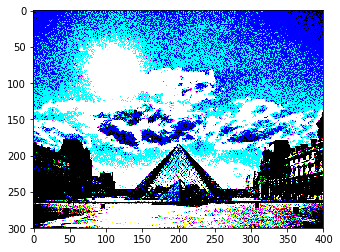

In [12]:
generated_image = generate_noise_image(content_image,noise_ratio=0.6)
imshow(generated_image[0])

In [13]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print (model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

In [14]:
sess.run(model['input'].assign(content_image))
out = model['conv4_2']
a_C = sess.run(out)
print (a_C.shape)
a_G = out # At this point, a_G is a tensor and hasn't been evaluated. 
J_content = compute_content_cost(a_C, a_G)

(1, 38, 50, 512)


In [15]:
sess.run(model['input'].assign(style_image))
J_style = compute_style_cost(model, STYLE_LAYERS)

In [16]:
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

In [17]:
train_step = tf.train.AdamOptimizer(2.0).minimize(J)

In [18]:
def model_nn(sess,input_image, num_iterations = 20):
    sess.run(model['input'].assign(input_image)) # assign noisy image to model
    # model['input'] is the variable here. see how model graph was created in load_vgg_model()
    for i in range(num_iterations):
        _ = sess.run(train_step)
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])
        if i%20 == 0:      # Print every 20 iteration.
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            save_image("output/" + str(i) + ".png", generated_image)
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [ ]:
sess.run(tf.global_variables_initializer())
model_nn(sess, generated_image)

Iteration 0 :
total cost = 5061098500.0
content cost = 7882.195
style cost = 126525496.0


**Expected Output**:

<table>
    <tr>
        <td>
            **Iteration 0 : **
        </td>
        <td>
           total cost = 5.05035e+09 <br>
           content cost = 7877.67 <br>
           style cost = 1.26257e+08
        </td>
    </tr>

</table>

In [ ]:
writer = tf.summary.FileWriter("output", sess.graph)  # this is must
print (sess.run(train_step)) # whatever you want to compute
writer.close()    # this is must

In [ ]:
print (tf.__version__)  # works with tf 1.1 and 1.2 alteast